In [1]:
import sys, os
import numpy as np
import glob
import datetime
import json
import ipdb
deb = ipdb.set_trace

# MRI analysis imports
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter
import nibabel as nb

sys.path.append("{}/../../../utils".format(os.getcwd()))
from gifti_utils import make_gifti_image, load_gifti_image


In [5]:
# subject = 'sub-02'
# dir_data = '/home/mszinte/disks/meso_S/data/RetinoMaps'
# dir_code = '/home/mszinte/disks/meso_H/projects/RetinoMaps'
# input_vd = '{}/derivatives/vdm/vdm.npy'.format(dir_data)
# input_fn_fsnative = '{}/derivatives/pp_data/{}/func/fmriprep_dct/fsnative/{}_ses-01_task-pRF_run-01_hemi-L_space-fsnative_dct_bold.func.gii'.format(
#     dir_data, subject, subject)

subject = 'sub-02'
dir_data = '/Users/uriel/disks/meso_shared/RetinoMaps'
dir_code = '/Users/uriel/disks/meso_H/projects/RetinoMaps'
input_vd = '{}/derivatives/vdm/vdm.npy'.format(dir_data)
input_fn_fsnative = '{}/derivatives/pp_data/{}/func/fmriprep_dct_avg/fsnative/{}_task-pRF_hemi-L_fmriprep_dct_avg_bold.func.gii'.format(
    dir_data, subject, subject)



# Analysis parameters
with open('{}/analysis_code/settings.json'.format(dir_code)) as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
screen_size_cm = analysis_info['screen_size_cm']
screen_distance_cm = analysis_info['screen_distance_cm']
TR = analysis_info['TR']
grid_nr = analysis_info['grid_nr']
max_ecc_size = analysis_info['max_ecc_size']
n_jobs = 8
n_batches = 8

In [ ]:
# Get task specific visual design matrix
vdm = np.load(input_vd)

# Model parameters bound
sizes = max_ecc_size * np.linspace(0.1,1,grid_nr)**2
eccs = max_ecc_size * np.linspace(0.25,1,grid_nr)**2
polars = np.linspace(0, 2*np.pi, grid_nr)

In [ ]:
# Load fsnative data 
data_img_fsnative, data_fsnative = load_gifti_image(input_fn_fsnative)

In [74]:
# Create subsample of data
data_fsnative_ = data_fsnative[:,:]
#data_fsnative_ = data_fsnative[:,0:80000]

In [75]:
# compute how much data is pick from the full amount
data_fsnative_.shape[1]/data_fsnative.shape[1]

1.0

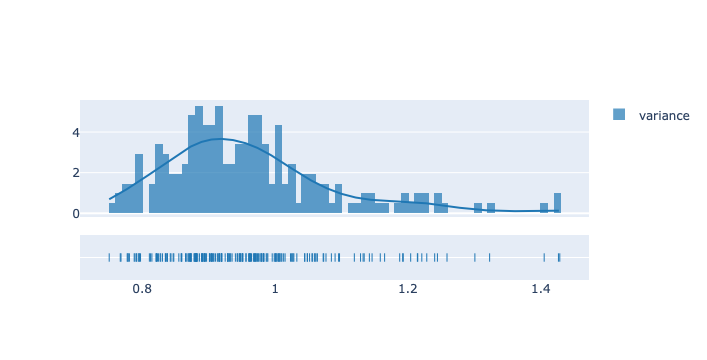

In [76]:
# Check and plot the variance of the vertices
data_var = np.var(data_fsnative_,axis=-1)

import plotly.figure_factory as ff
import numpy as np

x = data_var
hist_data = [x]
group_labels = ['variance'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels,bin_size=.01)
fig.show()

In [77]:
# determine gauss model
stimulus = PRFStimulus2D(screen_size_cm=screen_size_cm[1], 
                         screen_distance_cm=screen_distance_cm,
                         design_matrix=vdm, 
                         TR=TR)

gauss_model = Iso2DGaussianModel(stimulus=stimulus)

# grid fit
gauss_fitter = Iso2DGaussianFitter(data=data_fsnative_.T, model=gauss_model, n_jobs=n_jobs)
gauss_fitter.grid_fit(ecc_grid=eccs, 
                      polar_grid=polars, 
                      size_grid=sizes, 
                      verbose=False, 
                      n_batches=n_batches)

/home/mszinte/softwares/prfpy/prfpy/fit.py:441: RuntimeWarning: divide by zero encountered in true_divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/home/mszinte/softwares/prfpy/prfpy/fit.py:441: RuntimeWarning: invalid value encountered in true_divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/home/mszinte/softwares/prfpy/prfpy/fit.py:450: RuntimeWarning: invalid value encountered in multiply
  slopes[..., np.newaxis] *
/home/mszinte/softwares/prfpy/prfpy/fit.py:449: RuntimeWarning: invalid value encountered in subtract
  resid = np.linalg.norm((vox_data -
/home/mszinte/softwares/prfpy/prfpy/fit.py:441: RuntimeWarning: divide by zero encountered in true_divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/home/mszinte/softwares/prfpy/prfpy/fit.py:441: RuntimeWarning: invalid value encountered in true_divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/home/mszinte/softwares/prfpy/prfpy/f

In [ ]:
# iterative fit
gauss_fitter.iterative_fit(rsq_threshold=0.01, verbose=False)
gauss_fit = gauss_fitter.iterative_search_params

In [ ]:
gauss_fit_mat = np.zeros((data_fsnative_.shape[1],8))
gauss_pred_mat = np.zeros_like(data_fsnative_) 
for est in range(len(data_fsnative_.T)):
    gauss_fit_mat[est] = gauss_fit[est]
    gauss_pred_mat[:,est] = gauss_model.return_prediction(mu_x=gauss_fit[est][0], 
                                                          mu_y=gauss_fit[est][1], 
                                                          size=gauss_fit[est][2], 
                                                          beta=gauss_fit[est][3], 
                                                          baseline=gauss_fit[est][4])

In [ ]:
num_vert = 6
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=data_fsnative_[:,num_vert], name='data', mode='markers'))
fig.add_trace(go.Scatter(y=gauss_pred_mat[:,num_vert], name='Gauss model (R2={:1.2f})'.format(gauss_fit_mat[num_vert,-1])))
fig.show()

In [ ]:
# determine DN model
dn_model = Norm_Iso2DGaussianModel(stimulus=stimulus)
dn_fitter = Norm_Iso2DGaussianFitter(data=data_fsnative_.T, 
                                     model=dn_model, 
                                     n_jobs=n_jobs,
                                     use_previous_gaussian_fitter_hrf=True,
                                     previous_gaussian_fitter=gauss_fitter)

In [ ]:
# dn parameters
fixed_grid_baseline = 0
grid_bounds = [(0,1000),(0,1000)]
surround_size_grid = sizes
surround_amplitude_grid = np.linspace(0, 10, grid_nr)
surround_baseline_grid = np.linspace(0, 10, grid_nr)
neural_baseline_grid = np.linspace(0, 10, grid_nr)

dn_fitter.grid_fit(
    fixed_grid_baseline=fixed_grid_baseline,
    grid_bounds=grid_bounds,
    surround_amplitude_grid=surround_amplitude_grid,
    surround_size_grid=surround_size_grid,             
    surround_baseline_grid=surround_baseline_grid,
    neural_baseline_grid=neural_baseline_grid,
    n_batches=n_batches,
    rsq_threshold=0.0001,
    verbose=True,
    # hrf_1_grid=np.linspace(0,10,num),
    # hrf_2_grid=np.linspace(0,0,1)
)

In [ ]:
dn_fitter.iterative_fit(rsq_threshold=0.0001, verbose=True)
fit_fit_dn = dn_fitter.iterative_search_params

In [ ]:
dn_fit_mat = np.zeros((data_fsnative_.shape[1],12))
dn_pred_mat = np.zeros_like(data_fsnative_) 
for est in range(len(data_fsnative_.T)):
    dn_fit_mat[est] = fit_fit_dn[est]
    dn_pred_mat[:,est] = dn_model.return_prediction(mu_x=fit_fit_dn[est][0], 
                                                    mu_y=fit_fit_dn[est][1], 
                                                    prf_size=fit_fit_dn[est][2], 
                                                    prf_amplitude=fit_fit_dn[est][3], 
                                                    bold_baseline=fit_fit_dn[est][4],
                                                    srf_amplitude=fit_fit_dn[est][5],
                                                    srf_size=fit_fit_dn[est][6],
                                                    neural_baseline=fit_fit_dn[est][7],
                                                    surround_baseline=fit_fit_dn[est][8]
                                                   )

In [ ]:
num_vert = 3
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=data_fsnative_[:,num_vert], name='data', mode='markers'))
fig.add_trace(go.Scatter(y=gauss_pred_mat[:,num_vert], name='Gauss model (R2={:1.2f})'.format(gauss_fit_mat[num_vert,-1])))
fig.add_trace(go.Scatter(y=dn_pred_mat[:,num_vert], name='DN model (R2={:1.2f})'.format(dn_fit_mat[num_vert,-1])))
fig.show()

Performing unbounded, unconstrained minimization (Powell).
Optimization terminated successfully.
         Current function value: 179.912354
         Iterations: 5
         Function evaluations: 800
Performing unbounded, unconstrained minimization (Powell).
Optimization terminated successfully.
         Current function value: 128.204559
         Iterations: 7
         Function evaluations: 1034
Performing unbounded, unconstrained minimization (Powell).
Optimization terminated successfully.
         Current function value: 182.483063
         Iterations: 9
         Function evaluations: 1475
Performing unbounded, unconstrained minimization (Powell).
Optimization terminated successfully.
         Current function value: 174.526184
         Iterations: 11
         Function evaluations: 1731
Performing unbounded, unconstrained minimization (Powell).
Optimization terminated successfully.
         Current function value: 169.096497
         Iterations: 13
         Function evaluations: 2084